# Identifying LLM "Tells": N-gram Analysis of Human vs. AI Text

**Objective:** This notebook aims to identify characteristic words and phrases (n-grams) that are statistically more likely to appear in text generated by a Large Language Model compared to human-written text. This process helps in understanding the stylistic differences between human and AI-generated content.

**Methodology:**
1.  **Dataset:** Uses the `databricks/databricks-dolly-15k` dataset, which contains instruction-following records.
2.  **LLM Generation:** For a sample of human responses, corresponding responses are generated using a specified Gemini model via Google's Vertex AI. The generation process attempts to match the length of the human response.
3.  **N-gram Analysis:**
    *   Both human and LLM responses are preprocessed (lowercase, punctuation removal, stopword removal).
    *   Unigrams and bigrams are extracted from both corpora.
    *   Log-Likelihood Ratio is calculated to identify n-grams that are significantly overrepresented in the LLM corpus compared to the human corpus.
    *   Frequency thresholds are applied to filter out very rare n-grams.
4.  **Exploration & Visualization:**
    *   The top "tells" (n-grams with high LLR scores) are displayed.
    *   Functionality is provided to search for specific tells within the LLM-generated responses.
    *   The distribution of response lengths (word count) between human and LLM responses is compared and visualized.



In [ ]:
#@title Setup and Authentication

# --- Install required packages ---
%pip install -U --quiet google-genai datasets gcsfs torch nltk tqdm matplotlib seaborn fastai torchvision torchaudio wordfreq

# --- Authenticate user (if in Google Colab) and download NLTK data ---
import sys
import nltk

if "google.colab" in sys.modules:
    from google.colab import auth
    print("Authenticating in Google Colab...")
    auth.authenticate_user()
    print("Authentication successful.")

# --- Download required NLTK packages ---
print("\nDownloading NLTK data...")
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab', quiet=True)
print("NLTK setup complete.")

In [ ]:
#@title Configuration Panel

#@markdown ---
#@markdown ### **Google Cloud & Vertex AI Project Configuration**
#@markdown You must set your Google Cloud Project ID and location.
PROJECT_ID = "your-project-id" #@param {type:"string"}
LOCATION = "us-central1" #@param {type:"string"}

#@markdown ---
#@markdown ### **Model & Dataset Configuration**
MODEL_ID = "gemini-2.5-flash-preview-05-20" #@param ["gemini-2.5-flash-preview-05-20", "gemini-2.5-pro-preview-05-06", "gemini-2.0-flash"]
DATASET_NAME = "databricks/databricks-dolly-15k" #@param {type:"string"}
SAMPLE_SIZE = 1000 #@param {type:"slider", min:50, max:15000, step:50}

#@markdown ---
#@markdown ### **LLM Generation Configuration**
#@markdown This controls how the LLM generates text to match human responses.
WORD_TO_TOKEN_RATIO = 1.33  #@param {type:"number"}
BUFFER_PERCENTAGE = 0.35    #@param {type:"slider", min:0.1, max:1.0, step:0.05}
MIN_TOKENS = 50             #@param {type:"integer"}
MAX_TOKENS_OVERALL = 1024   #@param {type:"integer"}
TEMPERATURE = 0.7           #@param {type:"slider", min:0.0, max:1.0, step:0.1}

#@markdown ---
#@markdown ### **N-gram Analysis Configuration**
#@markdown These parameters control the "tell" finding algorithm.
MIN_LLM_COUNT = 3             #@param {type:"slider", min:1, max:10, step:1}
GENERAL_FREQ_THRESHOLD = 1e-06 #@param {type:"number"}

In [3]:
#@title Import Libraries & Initialize Client

import os
import re
import pandas as pd
import numpy as np
import textwrap
from datasets import load_dataset
from tqdm.auto import tqdm
from scipy.stats import chi2_contingency
from nltk.corpus import stopwords
from nltk.util import ngrams
import wordfreq

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google GenAI
from google import genai
from google.genai.types import GenerateContentConfig, HarmBlockThreshold, HarmCategory, SafetySetting

# --- Initialize the Vertex AI Client ---
if not PROJECT_ID or "your-project-id" in PROJECT_ID:
    raise ValueError("You must set the PROJECT_ID in the configuration cell (Step 2).")

print(f"Initializing GenAI Client for project '{PROJECT_ID}' in location '{LOCATION}'...")
client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)
print(f"Client initialized successfully. Using model: {MODEL_ID}")

# --- Set up TQDM for pandas.progress_apply ---
tqdm.pandas()

Initializing GenAI Client for project 'vertical-datum-418119' in location 'us-central1'...
Client initialized successfully. Using model: gemini-2.5-flash-preview-05-20


In [4]:
#@title Define Helper Functions

# --- Text Preprocessing Function ---
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    """Cleans, tokenizes, and removes stopwords from text."""
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    return [word for word in tokens if word.isalpha() and not word in stop_words]

# --- N-gram Analysis Functions ---
def calculate_log_likelihood(k1, n1, k2, n2):
    """Calculates the log-likelihood ratio for a word's frequency."""
    contingency_table = [[k1, n1 - k1], [k2, n2 - k2]]
    g, _, _, _ = chi2_contingency(contingency_table, lambda_="log-likelihood")
    return g

def find_tells(human_corpus_text, llm_corpus_text, n=1, min_count=3, freq_threshold=1e-6):
    """Finds LLM "tells" using Log-Likelihood Ratio and frequency filtering."""
    human_tokens = preprocess_text(human_corpus_text)
    llm_tokens = preprocess_text(llm_corpus_text)

    if not human_tokens or not llm_tokens:
        # Optional: Add a print warning if you want to be notified of this case
        # print(f"Warning: Empty token list for n={n}. Human tokens: {len(human_tokens)}, LLM tokens: {len(llm_tokens)}")
        return pd.DataFrame()

    # n1_total_tokens and n2_total_tokens are used for log-likelihood calculation,
    # representing the overall size of the original token pools.
    n1_total_tokens, n2_total_tokens = len(llm_tokens), len(human_tokens)

    # Generate n-grams. NLTK's ngrams returns tuples. FreqDist handles single words or tuples.
    llm_ngrams_list = list(ngrams(llm_tokens, n)) if n > 1 else llm_tokens
    human_ngrams_list = list(ngrams(human_tokens, n)) if n > 1 else human_tokens

    if not llm_ngrams_list or not human_ngrams_list:
        # Optional: Add a print warning
        # print(f"Warning: Empty n-gram list for n={n}. LLM n-grams: {len(llm_ngrams_list)}, Human n-grams: {len(human_ngrams_list)}")
        return pd.DataFrame()

    llm_freq_dist = nltk.FreqDist(llm_ngrams_list)
    human_freq_dist = nltk.FreqDist(human_ngrams_list)
    results = []

    # Denominators for proportional frequency calculation: total number of n-grams in each corpus.
    llm_total_ngrams = len(llm_ngrams_list)
    human_total_ngrams = len(human_ngrams_list)

    if llm_total_ngrams == 0 or human_total_ngrams == 0:
        # Optional: Add a print warning
        # print(f"Warning: Zero total n-grams for n={n}. LLM total: {llm_total_ngrams}, Human total: {human_total_ngrams}")
        return pd.DataFrame()

    for ngram_item, k1 in llm_freq_dist.items(): # ngram_item is a tuple for n>1, or a word string for n=1
        if k1 < min_count:
            continue

        # Ensure words_in_ngram is an iterable of individual words from the ngram_item
        words_in_ngram = list(ngram_item) if isinstance(ngram_item, tuple) else [ngram_item]

        # Check general frequency of ALL words in the ngram using wordfreq
        # If any word in the ngram is below the general frequency threshold, skip this ngram
        # Using wordfreq.word_frequency with 'best' wordlist and minimum=0.0 makes it robust to OOV words (returns 0.0)
        if any(wordfreq.word_frequency(word, 'en', wordlist='best', minimum=0.0) < freq_threshold for word in words_in_ngram):
            continue

        k2 = human_freq_dist[ngram_item]

        # Calculate proportional frequencies of the n-gram within their respective n-gram lists
        prop_freq_llm = k1 / llm_total_ngrams
        prop_freq_human = k2 / human_total_ngrams

        if prop_freq_llm <= prop_freq_human: # LLM proportional frequency must be higher
            continue

        # Log-likelihood uses the total number of tokens from the original corpora
        llr = calculate_log_likelihood(k1, n1_total_tokens, k2, n2_total_tokens)
        results.append({
            'ngram': ' '.join(ngram_item) if isinstance(ngram_item, tuple) else ngram_item,
            'log_likelihood': llr,
            'llm_freq': prop_freq_llm, # Proportional frequency of the n-gram
            'human_freq': prop_freq_human, # Proportional frequency of the n-gram
            'llm_count': k1,
            'human_count': k2
        })

    if not results: return pd.DataFrame()
    return pd.DataFrame(results).sort_values(by='log_likelihood', ascending=False)

# --- Visualization Function ---
def plot_tells(df, title):
    """Creates a bar plot of the top tells based on Log-Likelihood score."""
    if df.empty:
        print(f"Cannot plot: {title} - DataFrame is empty.")
        return
    plt.figure(figsize=(12, 10))
    plot_data = df.head(20)
    sns.barplot(data=plot_data, x='log_likelihood', y='ngram', palette='viridis_r', hue='ngram', legend=False)
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Log-Likelihood Score (Higher is a stronger "tell")', fontsize=12)
    plt.ylabel('N-gram', fontsize=12)
    plt.tight_layout()
    plt.show()

# --- LLM Generation Function ---
def generate_response_for_row(row, model_id):
    """Generates a LLM response for a single row of the DataFrame."""
    human_response = str(row.get('response', ''))
    human_word_count = len(re.findall(r'\w+', human_response))
    target_tokens = human_word_count * WORD_TO_TOKEN_RATIO
    dynamic_limit = int(target_tokens * (1 + BUFFER_PERCENTAGE))
    final_limit = int(max(MIN_TOKENS, min(MAX_TOKENS_OVERALL, dynamic_limit)))

    generation_config = GenerateContentConfig(
        temperature=TEMPERATURE,
        thinking_config=genai.types.ThinkingConfig(thinking_budget=0),
        max_output_tokens=final_limit,
        safety_settings=[
            SafetySetting(category=HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT, threshold=HarmBlockThreshold.BLOCK_NONE),
            SafetySetting(category=HarmCategory.HARM_CATEGORY_HARASSMENT, threshold=HarmBlockThreshold.BLOCK_NONE),
            SafetySetting(category=HarmCategory.HARM_CATEGORY_HATE_SPEECH, threshold=HarmBlockThreshold.BLOCK_NONE),
            SafetySetting(category=HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT, threshold=HarmBlockThreshold.BLOCK_NONE),
        ]
    )

    instruction = row['instruction']
    context = row.get('context')
    prompt = f"Based on the following context, please answer the instruction.\n\n--- CONTEXT ---\n{context}\n\n--- INSTRUCTION ---\n{instruction}" if context and isinstance(context, str) and len(context.strip()) > 10 else instruction

    try:
        response = client.models.generate_content(model=MODEL_ID, contents=prompt, config=generation_config)
        return response.text.strip()
    except Exception as e:
        print(f"Error for row {row.name} (limit {final_limit}): {e}")
        return "MODEL_GENERATION_ERROR"

print("Helper functions defined.")

Helper functions defined.


In [5]:
#@title Load Dataset and Create Sample

print(f"Loading '{DATASET_NAME}' dataset...")
dolly_dataset = load_dataset(DATASET_NAME)
dolly_df = dolly_dataset['train'].to_pandas()
print(f"Dataset loaded. Total records: {len(dolly_df)}")

# --- Create a smaller random sample to work with ---
sample_df = dolly_df.sample(n=SAMPLE_SIZE, random_state=42).copy()
print(f"\nCreated a random sample of {len(sample_df)} records for analysis.")
display(sample_df.head())

Loading 'databricks/databricks-dolly-15k' dataset...


README.md:   0%|          | 0.00/8.20k [00:00<?, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Dataset loaded. Total records: 15011

Created a random sample of 100 records for analysis.


,instruction,context,response,category
2957,What are the best selling albums of all time? ...,,Best selling albums of all time:\n\n- Michael ...,brainstorming
11845,"Given this paragraph about magnesium, what is ...",Elemental magnesium is a gray-white lightweigh...,The melting point of magnesium is 650 °C.,closed_qa
9230,How do I pick the best bananas?,,It depends on when you want to eat them. If yo...,general_qa
930,Extract the teams that Bob Sanders played thro...,"Demond ""Bob"" Sanders (born February 24, 1981) ...","Iowa Hawkeyes, Indianapolis Colts, San Diego C...",information_extraction
7671,Who was the 27th president of the United State...,,William Howard Taft was the 27th president of ...,open_qa


In [8]:
#@title Run LLM Generation
# This is the most time-consuming and potentially costly step.
# If you have already run this and saved a checkpoint, you can skip this cell.

print(f"Starting LLM generation for {len(sample_df)} samples...")
print("This process can be time-consuming. You can track progress below.")

# --- Apply the generation function to the sample DataFrame ---
sample_df['llm_response'] = sample_df.progress_apply(
    generate_response_for_row,
    axis=1,
    model_id=MODEL_ID
)

print("\n--- Generation Complete ---")
display(sample_df.head())

Starting LLM generation for 100 samples...
This process can be time-consuming. You can track progress below.


  0%|          | 0/100 [00:00<?, ?it/s]


--- Generation Complete ---


,instruction,context,response,category,llm_response
2957,What are the best selling albums of all time? ...,,Best selling albums of all time:\n\n- Michael ...,brainstorming,Here's a list of the best-selling albums of al...
11845,"Given this paragraph about magnesium, what is ...",Elemental magnesium is a gray-white lightweigh...,The melting point of magnesium is 650 °C.,closed_qa,The melting point of magnesium in Celsius is 6...
9230,How do I pick the best bananas?,,It depends on when you want to eat them. If yo...,general_qa,"Picking the ""best"" bananas really depends on w..."
930,Extract the teams that Bob Sanders played thro...,"Demond ""Bob"" Sanders (born February 24, 1981) ...","Iowa Hawkeyes, Indianapolis Colts, San Diego C...",information_extraction,"Indianapolis Colts, San Diego Chargers"
7671,Who was the 27th president of the United State...,,William Howard Taft was the 27th president of ...,open_qa,The 27th president of the United States of Ame...


In [6]:
#@title Save Results to a CSV Checkpoint

# --- Save the results to a CSV to avoid re-running generation ---
checkpoint_filename = f"dolly_sample_{SAMPLE_SIZE}_with_llm_responses.csv"
print(f"Saving DataFrame with LLM responses to '{checkpoint_filename}'...")
sample_df.to_csv(checkpoint_filename, index=False)
print("Checkpoint saved successfully!")


# --- To skip generation in the future, you can load the data from here ---
# 1. In the menu, go to Runtime -> Interrupt Execution if Step 6 is running.
# 2. In the menu, go to Runtime -> Run After for this cell.
# 3. Comment out the code in "Step 6: Generate LLM Corpus".
# 4. Uncomment the lines below to load your saved data.

# print(f"\nLoading data from checkpoint '{checkpoint_filename}'...")
# sample_df = pd.read_csv(checkpoint_filename).fillna('') # use fillna('') to handle potential empty context
# print("Data loaded successfully.")

Saving DataFrame with LLM responses to 'dolly_sample_100_with_llm_responses.csv'...
Checkpoint saved successfully!


In [9]:
#@title Run N-gram "Tell" Analysis

print("Performing global analysis with LLR and frequency filtering...")

# --- Combine all text into two large corpora ---
human_corpus_full = " ".join(sample_df['response'].dropna())
llm_corpus_full = " ".join(sample_df['llm_response'].dropna())

# --- Find unigram and bigram tells ---
unigram_tells = find_tells(human_corpus_full, llm_corpus_full, n=1, min_count=MIN_LLM_COUNT, freq_threshold=GENERAL_FREQ_THRESHOLD)
bigram_tells = find_tells(human_corpus_full, llm_corpus_full, n=2, min_count=MIN_LLM_COUNT, freq_threshold=GENERAL_FREQ_THRESHOLD)

print("\n--- Top 20 Unigram 'Tells' (Sorted by Log-Likelihood) ---")
display(unigram_tells.head(20))

print("\n--- Top 20 Bigram 'Tells' (Sorted by Log-Likelihood) ---")
display(bigram_tells.head(20))

Performing global analysis with LLR and frequency filtering...

--- Top 20 Unigram 'Tells' (Sorted by Log-Likelihood) ---


,ngram,log_likelihood,llm_freq,human_freq,llm_count,human_count
0,heres,37.716269,0.009836,0.000000,33,0
42,breakdown,18.834676,0.005365,0.000000,18,0
196,sources,12.681839,0.003875,0.000000,13,0
69,lets,8.867456,0.003875,0.000328,13,1
191,cell,7.876548,0.002683,0.000000,9,0
51,core,5.546941,0.002086,0.000000,7,0
70,break,5.546941,0.002086,0.000000,7,0
88,often,4.564203,0.003279,0.000656,11,2
7,primarily,4.413192,0.001788,0.000000,6,0
24,based,4.413192,0.001788,0.000000,6,0



--- Top 20 Bigram 'Tells' (Sorted by Log-Likelihood) ---


,ngram,log_likelihood,llm_freq,human_freq,llm_count,human_count
2,heres breakdown,17.595351,0.005069,0.000000,17,0
17,food sources,10.261000,0.003280,0.000000,11,0
0,heres list,5.546941,0.002087,0.000000,7,0
5,lets break,5.546941,0.002087,0.000000,7,0
13,movement wood,3.310500,0.001491,0.000000,5,0
22,blood cell,3.310500,0.001491,0.000000,5,0
3,breakdown key,2.253559,0.001193,0.000000,4,0
12,dimensional movement,2.253559,0.001193,0.000000,4,0
23,cell formation,2.253559,0.001193,0.000000,4,0
21,red blood,1.296808,0.001491,0.000328,5,1


In [10]:
#@title Explore a Specific "Tell"
# This cell finds and displays examples of any specified "tell".

# <<< ACTION REQUIRED >>>
# STEP 1: Define the tell you want to find from your analysis results.
# -------------------------------------------------------------------
# --- For a UNIGRAM (a single word) ---
tell_to_find = "delve"

# --- For a BIGRAM (a two-word phrase) ---
# tell_to_find = ("delve", "into")
# -------------------------------------------------------------------
# STEP 2: Run this cell.


# --- Build the search pattern dynamically (stopword-aware for bigrams) ---
is_bigram = isinstance(tell_to_find, tuple)
if is_bigram:
    stop_words_pattern = '|'.join(list(stopwords.words('english')))
    word1 = re.escape(tell_to_find[0])
    word2 = re.escape(tell_to_find[1])
    in_between_pattern = r'(\s|' + stop_words_pattern + r'|[^A-Za-z0-9\s])+'
    search_pattern = r'\b(' + word1 + in_between_pattern + word2 + r')\b'
    display_name = f"'{' '.join(tell_to_find)}'"
else:
    search_pattern = r'\b' + re.escape(str(tell_to_find)) + r'\b'
    display_name = f"'{tell_to_find}'"

print(f"Searching for instances of the tell: {display_name} (case-insensitive)\n")
instances = sample_df[sample_df['llm_response'].str.contains(search_pattern, case=False, na=False)]

print(f"Found {len(instances)} instances of {display_name} in the LLM responses.")
print("-" * 80)

if instances.empty:
    print("No matches found.")
else:
    for index, row in instances.iterrows():
        print(f"Instance in Row #{index} | Category: {row.get('category', 'N/A')}")
        print(f"Instruction: {textwrap.fill(row['instruction'], width=80)}\n")

        response_text = row['llm_response']
        highlighted_response = re.sub(f'({search_pattern})', r'>> \1 <<', response_text, flags=re.IGNORECASE)

        print(f"LLM Response (highlighted):")
        print(textwrap.fill(highlighted_response, width=80))
        print("-" * 80)

Searching for instances of the tell: 'delve' (case-insensitive)

Found 0 instances of 'delve' in the LLM responses.
--------------------------------------------------------------------------------
No matches found.


Calculating and comparing response length distributions...


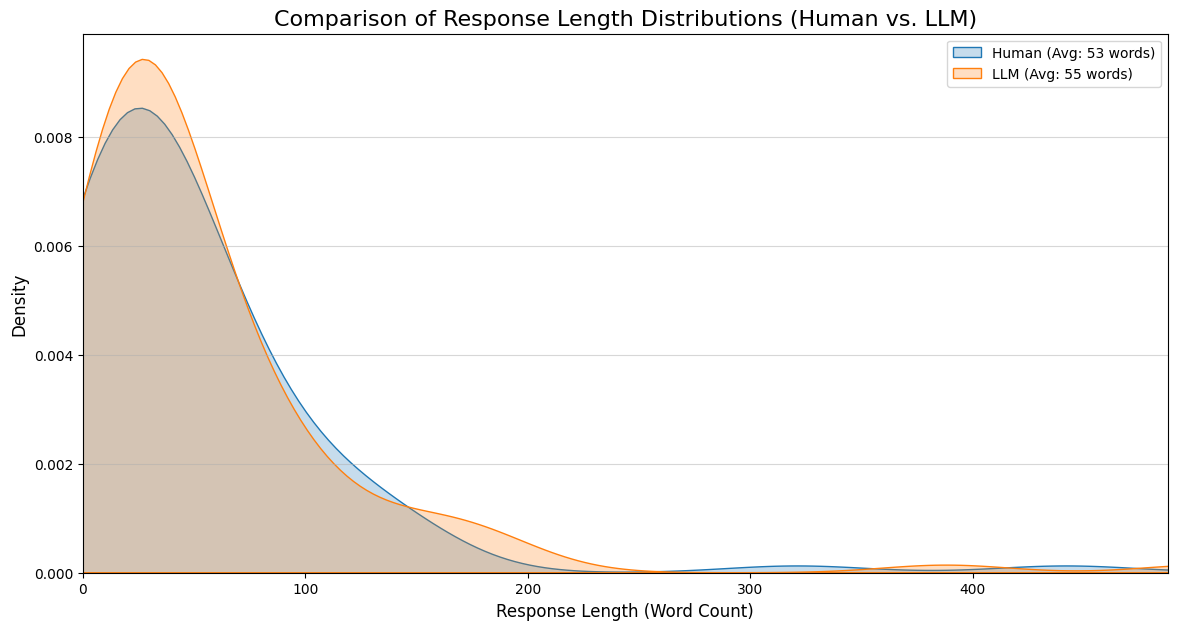

In [11]:
#@title Compare Response Length Distributions

print("Calculating and comparing response length distributions...")

# --- Calculate word counts for both corpora ---
word_count_lambda = lambda x: len(re.findall(r'\w+', str(x)))
sample_df['human_word_count'] = sample_df['response'].apply(word_count_lambda)
sample_df['llm_word_count'] = sample_df['llm_response'].apply(word_count_lambda)

# --- Get statistics ---
human_stats = sample_df['human_word_count'].describe()
llm_stats = sample_df['llm_word_count'].describe()

# --- Visualize the Distributions ---
plt.figure(figsize=(14, 7))
sns.kdeplot(data=sample_df, x='human_word_count', fill=True, label=f"Human (Avg: {human_stats['mean']:.0f} words)", clip=(0, None))
sns.kdeplot(data=sample_df, x='llm_word_count', fill=True, label=f"LLM (Avg: {llm_stats['mean']:.0f} words)", clip=(0, None))

plt.title('Comparison of Response Length Distributions (Human vs. LLM)', fontsize=16)
plt.xlabel('Response Length (Word Count)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

# Set x-limit to the 99th percentile for a clearer view
plt.xlim(0, sample_df['human_word_count'].quantile(0.99) * 1.1)
plt.show()